In [1]:
import pandas as pd
import numpy as np
import joblib
import time
from pathlib import Path
import sys
import sklearn
import xgboost
import lightgbm

# Model selection and evaluation
from sklearn.model_selection import StratifiedKFold, cross_validate, learning_curve, validation_curve
from sklearn.metrics import (
    f1_score, accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, log_loss, roc_auc_score,
    make_scorer, cohen_kappa_score, matthews_corrcoef
)

# Classical ML models
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Statistical tests
from scipy import stats
import scikit_posthocs as sp_posthoc

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load sparse matrices
import scipy.sparse as sp_sparse

print(f"Python Version: {sys.version}")
print(f"scikit-learn Version: {sklearn.__version__}")
print(f"XGBoost Version: {xgboost.__version__}")
print(f"LightGBM Version: {lightgbm.__version__}")


Python Version: 3.11.14 (main, Oct 31 2025, 23:04:14) [Clang 21.1.4 ]
scikit-learn Version: 1.7.2
XGBoost Version: 3.1.2
LightGBM Version: 4.6.0


In [2]:
# 4.1 Load preprocessed data and features

DATA_DIR = Path('../data')
FEATURES_DIR = Path('features')
MODELS_DIR = Path('models')
RESULTS_DIR = Path('results')
RESULTS_DIR.mkdir(exist_ok=True)

# Load train and validation data
train_df = pd.read_csv(DATA_DIR / 'train.csv')
val_df = pd.read_csv(DATA_DIR / 'val.csv')
test_df = pd.read_csv(DATA_DIR / 'test.csv')

print(f"Train: {train_df.shape}")
print(f"Val: {val_df.shape}")
print(f"Test: {test_df.shape}")

# Load best features from Step 3 (char-enhanced hybrid)
X_train = sp_sparse.load_npz(FEATURES_DIR / 'X_train_hybrid.npz')
X_val = sp_sparse.load_npz(FEATURES_DIR / 'X_val_hybrid.npz')
y_train = train_df['label'].values
y_val = val_df['label'].values

print(f"\nFeature matrix shape: {X_train.shape}")
print(f"Sparsity: {1.0 - X_train.nnz / (X_train.shape[0] * X_train.shape[1]):.4f}")



Train: (102000, 3)
Val: (18000, 3)
Test: (7600, 3)

Feature matrix shape: (102000, 100000)
Sparsity: 0.9942


In [3]:
# 4.2 Cross-Validation Framework Setup

cv_splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print(f"Cross-validation configuration:")
print(f"  Folds: 10")
print(f"  Stratified: Yes")
print(f"  Random state: 42")
print(f"\nFold class distributions:")
for fold_idx, (train_idx, val_idx) in enumerate(cv_splitter.split(X_train, y_train), 1):
    fold_dist = np.bincount(y_train[train_idx])
    print(f"  Fold {fold_idx}: {fold_dist}")


Cross-validation configuration:
  Folds: 10
  Stratified: Yes
  Random state: 42

Fold class distributions:
  Fold 1: [22950 22950 22950 22950]
  Fold 2: [22950 22950 22950 22950]
  Fold 3: [22950 22950 22950 22950]
  Fold 4: [22950 22950 22950 22950]
  Fold 5: [22950 22950 22950 22950]
  Fold 6: [22950 22950 22950 22950]
  Fold 7: [22950 22950 22950 22950]
  Fold 8: [22950 22950 22950 22950]
  Fold 9: [22950 22950 22950 22950]
  Fold 10: [22950 22950 22950 22950]


In [4]:
# Define evaluation metrics

scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'macro_f1': make_scorer(f1_score, average='macro'),
    'weighted_f1': make_scorer(f1_score, average='weighted'),
    'micro_f1': make_scorer(f1_score, average='micro'),
    'cohen_kappa': make_scorer(cohen_kappa_score),
    'mcc': make_scorer(matthews_corrcoef)
}

print("Evaluation metrics defined:")
for metric_name in scoring_metrics.keys():
    print(f"  - {metric_name}")


Evaluation metrics defined:
  - accuracy
  - macro_f1
  - weighted_f1
  - micro_f1
  - cohen_kappa
  - mcc


In [5]:
# Helper function for comprehensive model evaluation

def evaluate_model_cv(model, X, y, cv, model_name, scoring_metrics):
    """
    Perform cross-validation and return comprehensive results
    """
    print(f"\nEvaluating: {model_name}")
    print(f"  Model: {model}")
    
    start_time = time.time()
    
    # Cross-validation with multiple metrics
    cv_results = cross_validate(
        model, X, y, cv=cv, 
        scoring=scoring_metrics,
        return_train_score=True,
        return_estimator=True,
        n_jobs=-1
    )
    
    total_time = time.time() - start_time
    
    # Calculate statistics
    results = {
        'model_name': model_name,
        'model': model,
        'cv_results': cv_results,
        'total_time': total_time
    }
    
    # Print summary
    print(f"  Mean Macro-F1: {cv_results['test_macro_f1'].mean():.4f} +/- {cv_results['test_macro_f1'].std():.4f}")
    print(f"  Mean Accuracy: {cv_results['test_accuracy'].mean():.4f} +/- {cv_results['test_accuracy'].std():.4f}")
    print(f"  Total time: {total_time:.2f}s")
    
    return results

print("Evaluation function defined")


Evaluation function defined


In [6]:
# 4.3 Dummy Baselines - Establish Floor

dummy_models = {
    'Dummy_MostFrequent': DummyClassifier(strategy='most_frequent', random_state=42),
    'Dummy_Stratified': DummyClassifier(strategy='stratified', random_state=42),
    'Dummy_Uniform': DummyClassifier(strategy='uniform', random_state=42)
}

baseline_results = []

for model_name, model in dummy_models.items():
    results = evaluate_model_cv(model, X_train, y_train, cv_splitter, model_name, scoring_metrics)
    baseline_results.append(results)

print("\nDummy baseline evaluation complete")



Evaluating: Dummy_MostFrequent
  Model: DummyClassifier(random_state=42, strategy='most_frequent')
  Mean Macro-F1: 0.1000 +/- 0.0000
  Mean Accuracy: 0.2500 +/- 0.0000
  Total time: 1.50s

Evaluating: Dummy_Stratified
  Model: DummyClassifier(random_state=42, strategy='stratified')
  Mean Macro-F1: 0.2497 +/- 0.0032
  Mean Accuracy: 0.2498 +/- 0.0032
  Total time: 1.43s

Evaluating: Dummy_Uniform
  Model: DummyClassifier(random_state=42, strategy='uniform')
  Mean Macro-F1: 0.2503 +/- 0.0052
  Mean Accuracy: 0.2503 +/- 0.0052
  Total time: 0.79s

Dummy baseline evaluation complete


In [7]:
# 4.4 Naive Bayes Family

nb_models = {
    'MultinomialNB_alpha0.1': MultinomialNB(alpha=0.1),
    'MultinomialNB_alpha1.0': MultinomialNB(alpha=1.0),
    'ComplementNB_alpha0.1': ComplementNB(alpha=0.1),
    'ComplementNB_alpha1.0': ComplementNB(alpha=1.0),
    'BernoulliNB_alpha1.0': BernoulliNB(alpha=1.0)
}

nb_results = []

for model_name, model in nb_models.items():
    results = evaluate_model_cv(model, X_train, y_train, cv_splitter, model_name, scoring_metrics)
    nb_results.append(results)

print("\nNaive Bayes evaluation complete")



Evaluating: MultinomialNB_alpha0.1
  Model: MultinomialNB(alpha=0.1)
  Mean Macro-F1: 0.9018 +/- 0.0038
  Mean Accuracy: 0.9022 +/- 0.0037
  Total time: 1.42s

Evaluating: MultinomialNB_alpha1.0
  Model: MultinomialNB()
  Mean Macro-F1: 0.8975 +/- 0.0037
  Mean Accuracy: 0.8980 +/- 0.0036
  Total time: 1.45s

Evaluating: ComplementNB_alpha0.1
  Model: ComplementNB(alpha=0.1)
  Mean Macro-F1: 0.9010 +/- 0.0038
  Mean Accuracy: 0.9017 +/- 0.0037
  Total time: 1.46s

Evaluating: ComplementNB_alpha1.0
  Model: ComplementNB()
  Mean Macro-F1: 0.8984 +/- 0.0042
  Mean Accuracy: 0.8992 +/- 0.0041
  Total time: 1.46s

Evaluating: BernoulliNB_alpha1.0
  Model: BernoulliNB()
  Mean Macro-F1: 0.8834 +/- 0.0035
  Mean Accuracy: 0.8842 +/- 0.0034
  Total time: 3.13s

Naive Bayes evaluation complete


In [8]:
# 4.5 Logistic Regression - Multiple Configurations (FIXED)

lr_models = {
    'LogisticReg_C0.1_L2': LogisticRegression(C=0.1, penalty='l2', max_iter=1000, random_state=42, n_jobs=-1),
    'LogisticReg_C1.0_L2': LogisticRegression(C=1.0, penalty='l2', max_iter=1000, random_state=42, n_jobs=-1),
    'LogisticReg_C10.0_L2': LogisticRegression(C=10.0, penalty='l2', max_iter=1000, random_state=42, n_jobs=-1),
    # Skipped L1 - too slow on 100k features with saga solver
}

lr_results = []

for model_name, model in lr_models.items():
    results = evaluate_model_cv(model, X_train, y_train, cv_splitter, model_name, scoring_metrics)
    lr_results.append(results)

print("\nLogistic Regression evaluation complete (L1 skipped due to convergence issues)")



Evaluating: LogisticReg_C0.1_L2
  Model: LogisticRegression(C=0.1, max_iter=1000, n_jobs=-1, random_state=42)
  Mean Macro-F1: 0.9076 +/- 0.0030
  Mean Accuracy: 0.9078 +/- 0.0030
  Total time: 23.47s

Evaluating: LogisticReg_C1.0_L2
  Model: LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
  Mean Macro-F1: 0.9207 +/- 0.0035
  Mean Accuracy: 0.9208 +/- 0.0035
  Total time: 49.63s

Evaluating: LogisticReg_C10.0_L2
  Model: LogisticRegression(C=10.0, max_iter=1000, n_jobs=-1, random_state=42)
  Mean Macro-F1: 0.9182 +/- 0.0037
  Mean Accuracy: 0.9183 +/- 0.0037
  Total time: 74.57s

Logistic Regression evaluation complete (L1 skipped due to convergence issues)


In [9]:
# 4.6 Linear SVM

svm_models = {
    'LinearSVC_C0.1': LinearSVC(C=0.1, max_iter=2000, random_state=42),
    'LinearSVC_C1.0': LinearSVC(C=1.0, max_iter=2000, random_state=42),
    'LinearSVC_C10.0': LinearSVC(C=10.0, max_iter=2000, random_state=42),
}

svm_results = []

for model_name, model in svm_models.items():
    results = evaluate_model_cv(model, X_train, y_train, cv_splitter, model_name, scoring_metrics)
    svm_results.append(results)

print("\nLinear SVM evaluation complete")



Evaluating: LinearSVC_C0.1
  Model: LinearSVC(C=0.1, max_iter=2000, random_state=42)
  Mean Macro-F1: 0.9224 +/- 0.0033
  Mean Accuracy: 0.9226 +/- 0.0032
  Total time: 10.33s

Evaluating: LinearSVC_C1.0
  Model: LinearSVC(max_iter=2000, random_state=42)
  Mean Macro-F1: 0.9210 +/- 0.0034
  Mean Accuracy: 0.9211 +/- 0.0034
  Total time: 19.96s

Evaluating: LinearSVC_C10.0
  Model: LinearSVC(C=10.0, max_iter=2000, random_state=42)
  Mean Macro-F1: 0.9097 +/- 0.0028
  Mean Accuracy: 0.9098 +/- 0.0028
  Total time: 101.80s

Linear SVM evaluation complete


In [10]:
# 4.7 SGDClassifier

sgd_models = {
    'SGD_hinge_alpha1e-4': SGDClassifier(loss='hinge', alpha=1e-4, max_iter=1000, random_state=42, n_jobs=-1),
    'SGD_log_alpha1e-4': SGDClassifier(loss='log_loss', alpha=1e-4, max_iter=1000, random_state=42, n_jobs=-1),
    'SGD_modified_huber': SGDClassifier(loss='modified_huber', alpha=1e-4, max_iter=1000, random_state=42, n_jobs=-1),
}

sgd_results = []

for model_name, model in sgd_models.items():
    results = evaluate_model_cv(model, X_train, y_train, cv_splitter, model_name, scoring_metrics)
    sgd_results.append(results)

print("\nSGD Classifier evaluation complete")



Evaluating: SGD_hinge_alpha1e-4
  Model: SGDClassifier(n_jobs=-1, random_state=42)
  Mean Macro-F1: 0.9169 +/- 0.0033
  Mean Accuracy: 0.9172 +/- 0.0033
  Total time: 7.66s

Evaluating: SGD_log_alpha1e-4
  Model: SGDClassifier(loss='log_loss', n_jobs=-1, random_state=42)
  Mean Macro-F1: 0.9043 +/- 0.0032
  Mean Accuracy: 0.9047 +/- 0.0032
  Total time: 6.79s

Evaluating: SGD_modified_huber
  Model: SGDClassifier(loss='modified_huber', n_jobs=-1, random_state=42)
  Mean Macro-F1: 0.9231 +/- 0.0031
  Mean Accuracy: 0.9233 +/- 0.0031
  Total time: 8.23s

SGD Classifier evaluation complete


In [11]:
# 4.8 Tree-based Models - Random Forest

rf_models = {
    'RandomForest_n100': RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1),
    'RandomForest_n200_d20': RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1),
}

rf_results = []

for model_name, model in rf_models.items():
    results = evaluate_model_cv(model, X_train, y_train, cv_splitter, model_name, scoring_metrics)
    rf_results.append(results)

print("\nRandom Forest evaluation complete")



Evaluating: RandomForest_n100
  Model: RandomForestClassifier(n_jobs=-1, random_state=42)
  Mean Macro-F1: 0.8788 +/- 0.0035
  Mean Accuracy: 0.8795 +/- 0.0034
  Total time: 452.34s

Evaluating: RandomForest_n200_d20
  Model: RandomForestClassifier(max_depth=20, n_estimators=200, n_jobs=-1,
                       random_state=42)


/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  Mean Macro-F1: 0.8285 +/- 0.0043
  Mean Accuracy: 0.8299 +/- 0.0042
  Total time: 123.92s

Random Forest evaluation complete


In [12]:
# 4.9 Gradient Boosting - XGBoost 
'''
print("XGBoost evaluation with memory-optimized parameters for full dataset")

# Memory-optimized XGBoost models
xgb_models = {
    'XGBoost_n100_hist': XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        tree_method='hist',  # Histogram-based: uses QuantileDMatrix internally, much more memory efficient
        max_bin=256,  # Reduce bins for memory savings (default is 256, can go lower to 128)
        subsample=0.8,  # Use 80% of data per tree to reduce memory
        colsample_bytree=0.8,  # Use 80% of features per tree
        enable_sparse_data_optim=True,  # Optimize for sparse matrices - CRITICAL for your 100k features
        random_state=42,
        n_jobs=4,  # Limit to 4 cores instead of -1 to reduce parallel memory overhead
        verbosity=0
    ),
    'XGBoost_n200_hist': XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        tree_method='hist',
        max_bin=256,
        subsample=0.8,
        colsample_bytree=0.8,
        enable_sparse_data_optim=True,
        random_state=42,
        n_jobs=4,
        verbosity=0
    ),
}

# Use 5-fold CV instead of 10 to save time and memory
cv_splitter_xgb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_results = []

for model_name, model in xgb_models.items():
    results = evaluate_model_cv(
        model, 
        X_train, 
        y_train, 
        cv_splitter_xgb,  # 5-fold instead of 10-fold
        model_name, 
        scoring_metrics
    )
    xgb_results.append(results)

print("\nXGBoost evaluation complete on full dataset")
'''

'\nprint("XGBoost evaluation with memory-optimized parameters for full dataset")\n\n# Memory-optimized XGBoost models\nxgb_models = {\n    \'XGBoost_n100_hist\': XGBClassifier(\n        n_estimators=100,\n        learning_rate=0.1,\n        max_depth=5,\n        tree_method=\'hist\',  # Histogram-based: uses QuantileDMatrix internally, much more memory efficient\n        max_bin=256,  # Reduce bins for memory savings (default is 256, can go lower to 128)\n        subsample=0.8,  # Use 80% of data per tree to reduce memory\n        colsample_bytree=0.8,  # Use 80% of features per tree\n        enable_sparse_data_optim=True,  # Optimize for sparse matrices - CRITICAL for your 100k features\n        random_state=42,\n        n_jobs=4,  # Limit to 4 cores instead of -1 to reduce parallel memory overhead\n        verbosity=0\n    ),\n    \'XGBoost_n200_hist\': XGBClassifier(\n        n_estimators=200,\n        learning_rate=0.05,\n        max_depth=5,\n        tree_method=\'hist\',\n       

In [13]:
# 4.10 Gradient Boosting - LightGBM
'''
lgbm_models = {
    'LightGBM_n100': LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1, verbose=-1),
    'LightGBM_n200': LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42, n_jobs=-1, verbose=-1),
}

lgbm_results = []

for model_name, model in lgbm_models.items():
    results = evaluate_model_cv(model, X_train, y_train, cv_splitter, model_name, scoring_metrics)
    lgbm_results.append(results)

print("\nLightGBM evaluation complete")'''


'\nlgbm_models = {\n    \'LightGBM_n100\': LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1, verbose=-1),\n    \'LightGBM_n200\': LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42, n_jobs=-1, verbose=-1),\n}\n\nlgbm_results = []\n\nfor model_name, model in lgbm_models.items():\n    results = evaluate_model_cv(model, X_train, y_train, cv_splitter, model_name, scoring_metrics)\n    lgbm_results.append(results)\n\nprint("\nLightGBM evaluation complete")'

In [14]:
# 4.11 Consolidate all results

all_results = baseline_results + nb_results + lr_results + svm_results + sgd_results + rf_results

print(f"\nTotal models evaluated: {len(all_results)}")



Total models evaluated: 19


In [15]:
# 4.12 Create comprehensive results dataframe

results_summary = []

for result in all_results:
    cv_res = result['cv_results']
    
    summary = {
        'Model': result['model_name'],
        'Mean_Macro_F1': cv_res['test_macro_f1'].mean(),
        'Std_Macro_F1': cv_res['test_macro_f1'].std(),
        'Mean_Accuracy': cv_res['test_accuracy'].mean(),
        'Std_Accuracy': cv_res['test_accuracy'].std(),
        'Mean_Weighted_F1': cv_res['test_weighted_f1'].mean(),
        'Mean_Cohen_Kappa': cv_res['test_cohen_kappa'].mean(),
        'Mean_MCC': cv_res['test_mcc'].mean(),
        'Train_Macro_F1': cv_res['train_macro_f1'].mean(),
        'Total_Time_s': result['total_time'],
        'Time_per_Fold_s': result['total_time'] / 10
    }
    
    results_summary.append(summary)

results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values('Mean_Macro_F1', ascending=False)

print("\nTop 10 Models by Macro-F1:")
print(results_df.head(10).to_string(index=False))



Top 10 Models by Macro-F1:
                 Model  Mean_Macro_F1  Std_Macro_F1  Mean_Accuracy  Std_Accuracy  Mean_Weighted_F1  Mean_Cohen_Kappa  Mean_MCC  Train_Macro_F1  Total_Time_s  Time_per_Fold_s
    SGD_modified_huber       0.923109      0.003119       0.923294      0.003085          0.923109          0.897725  0.897849        0.956581      8.231978         0.823198
        LinearSVC_C0.1       0.922379      0.003280       0.922569      0.003244          0.922379          0.896758  0.896876        0.954088     10.325317         1.032532
        LinearSVC_C1.0       0.921007      0.003364       0.921118      0.003350          0.921007          0.894824  0.894873        0.993415     19.955194         1.995519
   LogisticReg_C1.0_L2       0.920688      0.003506       0.920833      0.003481          0.920688          0.894444  0.894513        0.961697     49.632076         4.963208
  LogisticReg_C10.0_L2       0.918158      0.003690       0.918255      0.003683          0.918158    

In [16]:
# Save results
results_df.to_csv(RESULTS_DIR / 'cv_results_summary.csv', index=False)
print("\nResults saved to results/cv_results_summary.csv")



Results saved to results/cv_results_summary.csv


/tmp/ipykernel_19131/51568714.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)


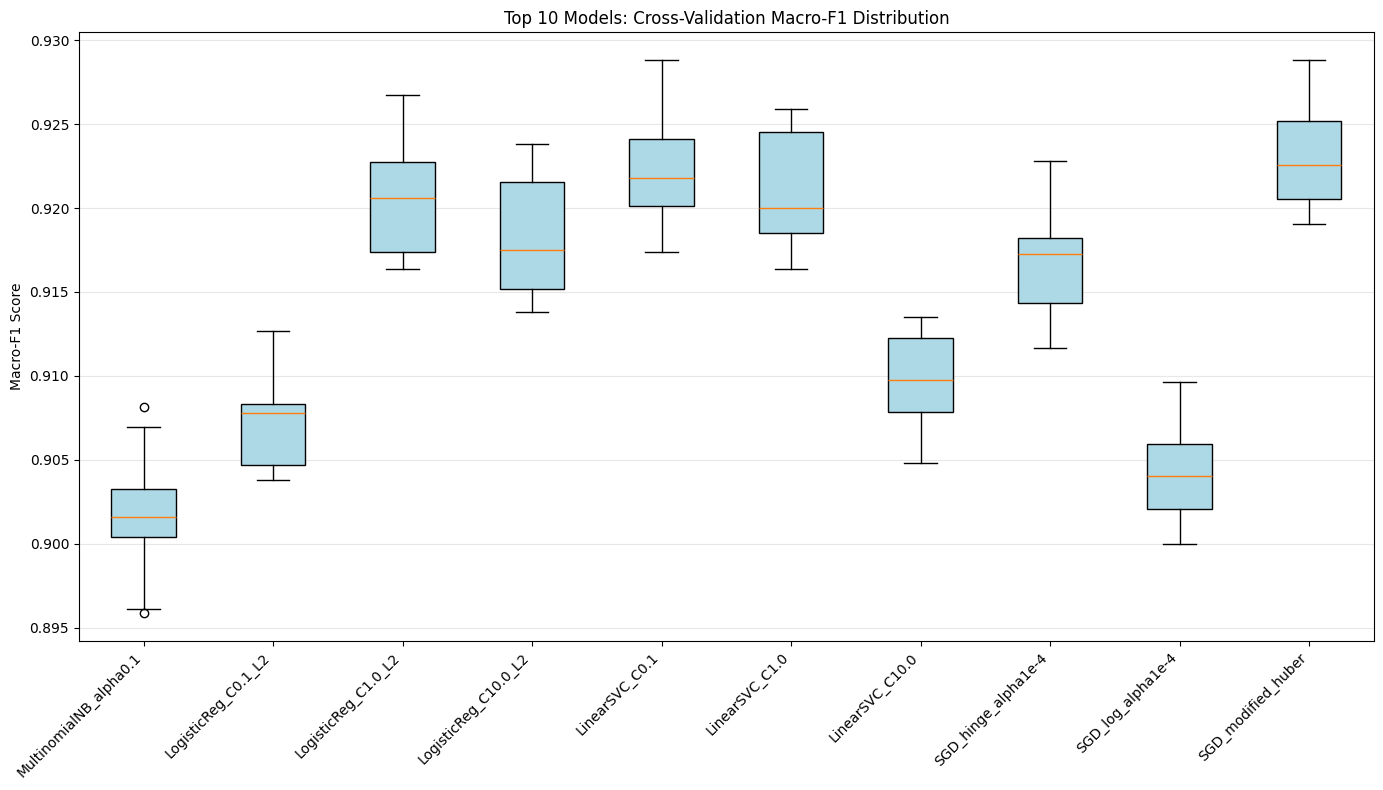

In [17]:
# 4.13 Visualize results - Box plots

top_n = 10
top_models = results_df.head(top_n)['Model'].tolist()

fig, ax = plt.subplots(figsize=(14, 8))

boxplot_data = []
labels = []

for result in all_results:
    if result['model_name'] in top_models:
        boxplot_data.append(result['cv_results']['test_macro_f1'])
        labels.append(result['model_name'])

bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True)

for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

ax.set_ylabel('Macro-F1 Score')
ax.set_title(f'Top {top_n} Models: Cross-Validation Macro-F1 Distribution')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'top_models_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()


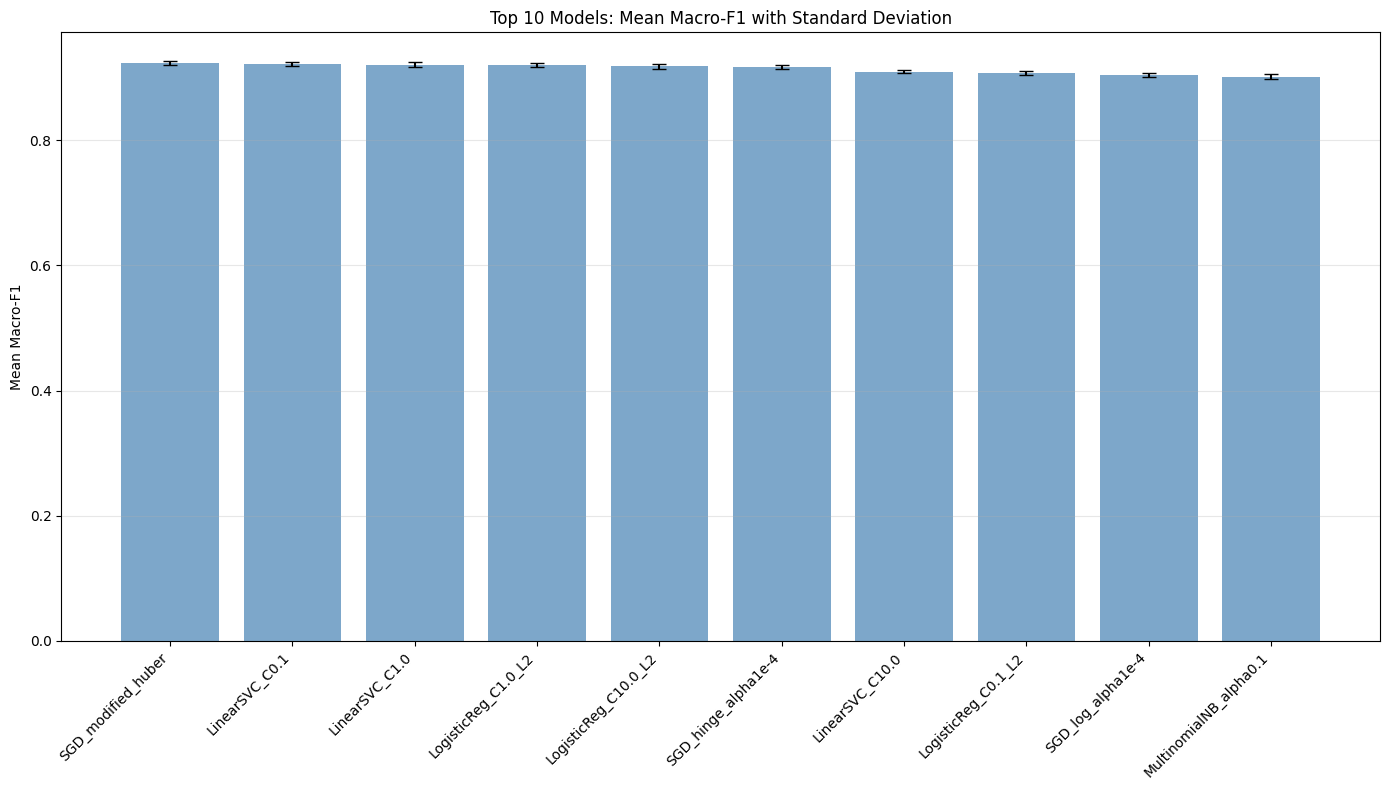

In [18]:
# Bar chart with error bars

fig, ax = plt.subplots(figsize=(14, 8))

x_pos = np.arange(len(top_models))
means = [results_df[results_df['Model'] == m]['Mean_Macro_F1'].values[0] for m in top_models]
stds = [results_df[results_df['Model'] == m]['Std_Macro_F1'].values[0] for m in top_models]

bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, color='steelblue')

ax.set_ylabel('Mean Macro-F1')
ax.set_title(f'Top {top_n} Models: Mean Macro-F1 with Standard Deviation')
ax.set_xticks(x_pos)
ax.set_xticklabels(top_models, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'top_models_barplot.png', dpi=300, bbox_inches='tight')
plt.show()


In [19]:
# 4.14 Get OOF predictions for best model

best_model_name = results_df.iloc[0]['Model']
best_model_result = [r for r in all_results if r['model_name'] == best_model_name][0]

print(f"\nGenerating OOF predictions for best model: {best_model_name}")

# Get OOF predictions
oof_predictions = np.zeros(len(y_train))
oof_probas = np.zeros((len(y_train), len(np.unique(y_train))))

for fold_idx, (train_idx, val_idx) in enumerate(cv_splitter.split(X_train, y_train)):
    estimator = best_model_result['cv_results']['estimator'][fold_idx]
    oof_predictions[val_idx] = estimator.predict(X_train[val_idx])
    
    if hasattr(estimator, 'predict_proba'):
        oof_probas[val_idx] = estimator.predict_proba(X_train[val_idx])

print(f"OOF Macro-F1: {f1_score(y_train, oof_predictions, average='macro'):.4f}")
print(f"OOF Accuracy: {accuracy_score(y_train, oof_predictions):.4f}")



Generating OOF predictions for best model: SGD_modified_huber
OOF Macro-F1: 0.9231
OOF Accuracy: 0.9233


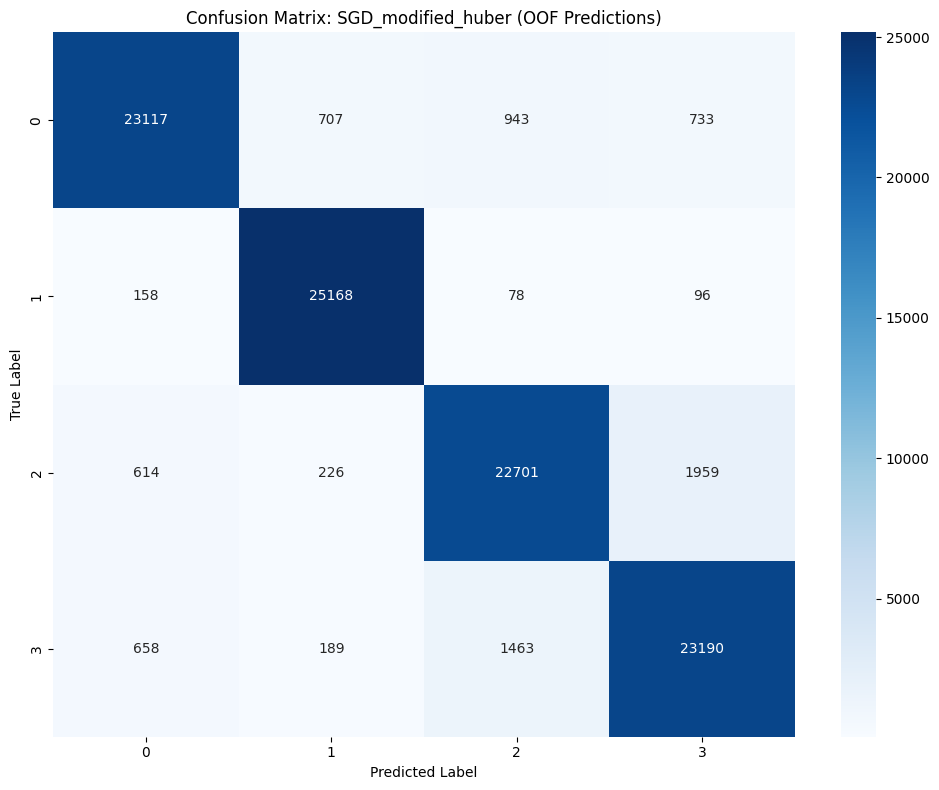

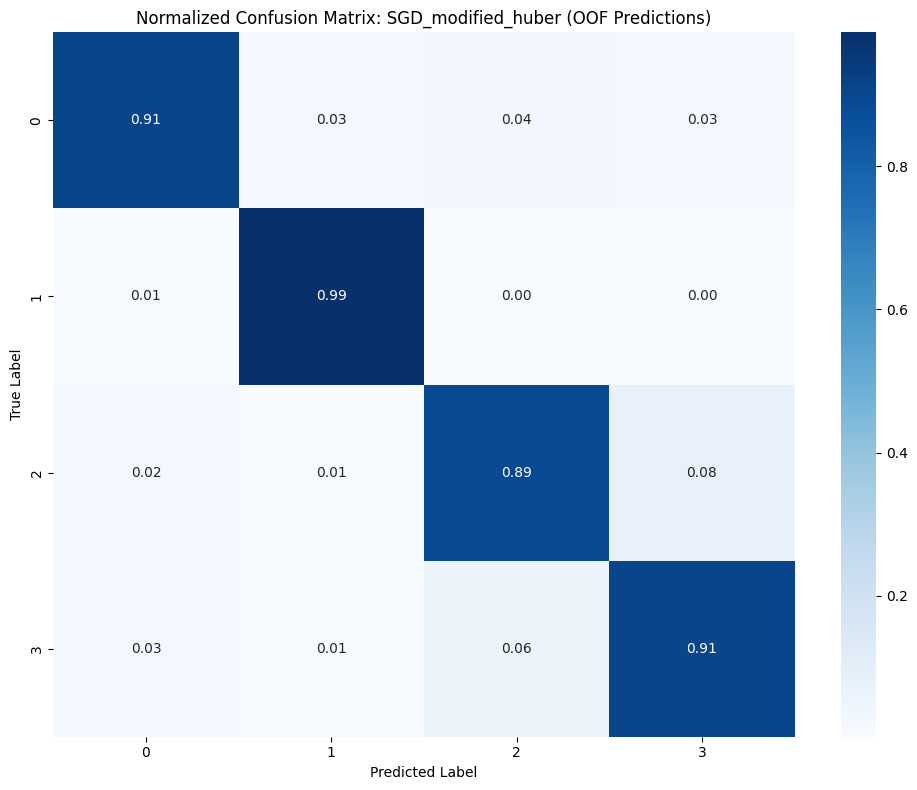

In [20]:
# 4.15 Confusion Matrix for best model

cm = confusion_matrix(y_train, oof_predictions)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title(f'Confusion Matrix: {best_model_name} (OOF Predictions)')
plt.tight_layout()
plt.savefig(RESULTS_DIR / f'{best_model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title(f'Normalized Confusion Matrix: {best_model_name} (OOF Predictions)')
plt.tight_layout()
plt.savefig(RESULTS_DIR / f'{best_model_name}_confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()


In [21]:
# 4.16 Classification report for best model

report = classification_report(y_train, oof_predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print(f"\nClassification Report: {best_model_name}")
print(report_df.to_string())

report_df.to_csv(RESULTS_DIR / f'{best_model_name}_classification_report.csv')



Classification Report: SGD_modified_huber
              precision    recall  f1-score        support
0              0.941744  0.906549  0.923812   25500.000000
1              0.957322  0.986980  0.971925   25500.000000
2              0.901370  0.890235  0.895768   25500.000000
3              0.892678  0.909412  0.900967   25500.000000
accuracy       0.923294  0.923294  0.923294       0.923294
macro avg      0.923279  0.923294  0.923118  102000.000000
weighted avg   0.923279  0.923294  0.923118  102000.000000


In [22]:
# 4.17 Statistical significance testing - Top 3 models

top_3_models = results_df.head(3)['Model'].tolist()
top_3_results = [r for r in all_results if r['model_name'] in top_3_models]

print("\nStatistical Significance Testing (Paired t-test):")
print("Comparing top 3 models pairwise")

for i in range(len(top_3_results)):
    for j in range(i+1, len(top_3_results)):
        model_i = top_3_results[i]
        model_j = top_3_results[j]
        
        scores_i = model_i['cv_results']['test_macro_f1']
        scores_j = model_j['cv_results']['test_macro_f1']
        
        t_stat, p_value = stats.ttest_rel(scores_i, scores_j)
        
        print(f"\n{model_i['model_name']} vs {model_j['model_name']}:")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Significant at 0.05: {'Yes' if p_value < 0.05 else 'No'}")



Statistical Significance Testing (Paired t-test):
Comparing top 3 models pairwise

LinearSVC_C0.1 vs LinearSVC_C1.0:
  t-statistic: 1.9496
  p-value: 0.0830
  Significant at 0.05: No

LinearSVC_C0.1 vs SGD_modified_huber:
  t-statistic: -4.4637
  p-value: 0.0016
  Significant at 0.05: Yes

LinearSVC_C1.0 vs SGD_modified_huber:
  t-statistic: -3.7085
  p-value: 0.0049
  Significant at 0.05: Yes


In [23]:
# 4.18 Save OOF predictions and models

# Save OOF predictions
np.save(RESULTS_DIR / f'{best_model_name}_oof_predictions.npy', oof_predictions)
np.save(RESULTS_DIR / f'{best_model_name}_oof_probas.npy', oof_probas)

# Train final model on full training set
print(f"\nTraining final {best_model_name} on full training set...")
final_model = best_model_result['model']
final_model.fit(X_train, y_train)

# Evaluate on validation set
val_pred = final_model.predict(X_val)
val_macro_f1 = f1_score(y_val, val_pred, average='macro')
val_accuracy = accuracy_score(y_val, val_pred)

print(f"Validation Macro-F1: {val_macro_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Save final model
joblib.dump(final_model, MODELS_DIR / f'{best_model_name}_final.pkl')
print(f"Final model saved to models/{best_model_name}_final.pkl")



Training final SGD_modified_huber on full training set...
Validation Macro-F1: 0.9274
Validation Accuracy: 0.9276
Final model saved to models/SGD_modified_huber_final.pkl


In [24]:
# 4.19 Summary statistics

print("\n" + "="*80)
print("BASELINE MODELING SUMMARY")
print("="*80)
print(f"\nTotal models evaluated: {len(all_results)}")
print(f"Best model: {best_model_name}")
print(f"Best CV Macro-F1: {results_df.iloc[0]['Mean_Macro_F1']:.4f} +/- {results_df.iloc[0]['Std_Macro_F1']:.4f}")
print(f"Validation Macro-F1: {val_macro_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"\nTop 5 models:")
for idx, row in results_df.head(5).iterrows():
    print(f"  {idx+1}. {row['Model']}: {row['Mean_Macro_F1']:.4f} +/- {row['Std_Macro_F1']:.4f}")



BASELINE MODELING SUMMARY

Total models evaluated: 19
Best model: SGD_modified_huber
Best CV Macro-F1: 0.9231 +/- 0.0031
Validation Macro-F1: 0.9274
Validation Accuracy: 0.9276

Top 5 models:
  17. SGD_modified_huber: 0.9231 +/- 0.0031
  12. LinearSVC_C0.1: 0.9224 +/- 0.0033
  13. LinearSVC_C1.0: 0.9210 +/- 0.0034
  10. LogisticReg_C1.0_L2: 0.9207 +/- 0.0035
  11. LogisticReg_C10.0_L2: 0.9182 +/- 0.0037
